In [101]:
from IPython.display import HTML
HTML('''<style>.CodeMirror{min-width:100% !important;}</style>''')

# A/B testing (practically speaking)

Tania Vasilikioti
Data Scientist @ Babbel

Ironback, Feb 13, 2020

## Why A/B test?


### Correlation vs causation

### Effects are often much smaller than what we think

In product and marketing changes/developments, we often think that a new feature release will have a "big bang" effect on the target metric. But the reality is often very far from it. Contributing factors: 
- Effect simply smaller than what we thought
- Day to day variation is too big to distinguish "with naked eye"
- Seasonality
- Many changes at the same time (unobserved and uncontrollable changes)

[Example of chart]

### Practical cases of A/B testing 

- Choose best option for a specific feature
- Evaluate if a particular solution solves the problem
- Evaluate if a feature is performing as well as we thought
- Choose best/optimal pricing technique
- Test better algorithm hyperparameters

### Examples of tests we run at Babbel

1. Prices page redesign
2. Email campaigns copy
3. Placement test in the registration funnel
4. Number of review items pending vs dot

## Today's challenge
Set up, analyze and present findings on the following experiment:
> We are data scientists in an e-commerce app, such as Zalando. We have been working with the Product Manager responsibile for the sign-up funnel. Some user testing has revealed that visitors to the app don't understand what the app does before it asks them to create an account, so they disengage and delete the app before creating an account and exploring. Therefore, the PM wants to check the following hypothesis: **"Adding introductory screens to the sign-up process before asking users to create an account will increase the proportion of users who sign up within 1 hour from starting the app by 5%"**

## Before the experiment starts

### The problem

### The experiment setup

- What does it look like? 
- Does the design actually correspond to the scientific question?
- What is the null and the alternative hypothesis?
- What kind of test do you think we'll be doing?

#### Example setup as a diagram

### Time for some coding: Power (duration) calculation

Before the experiment even starts, we need to determine how long (as a function of "how many observation") we need to wait to confidently detect an effect size 𝛿. 

**What is the power of the test again?**

<center>
<img src="http://www.columbia.edu/~cjd11/charles_dimaggio/DIRE/resources/power/curves.png" width="600" height="400" align="center"/>
</center>

[Source](http://www.columbia.edu/~cjd11/charles_dimaggio/DIRE/resources/power/curves.png)

And there actually exists a formula that connects: 
- sample size 
- desired effect size
- alpha
- beta
<center>
<img src="https://image.slidesharecdn.com/hypothesistestinglectureson02-140710153323-phpapp02/95/hypothesis-testing-lectures-15-638.jpg?cb=1405006484" width="600" height="400" align="center"/>
</center>

[Source](https://image.slidesharecdn.com/hypothesistestinglectureson02-140710153323-phpapp02/95/hypothesis-testing-lectures-15-638.jpg?cb=1405006484)

And yet another interpretation...
`Power = 1 - β`
> If the Null (H<sub>0</sub>) is **not** true, power is the probability that I will *correctly* reject it, i.e. 1-β, i.e. the probability that I will be able to detect this effect, given the sample size and α.

<center>
<img src="https://www.statisticshowto.datasciencecentral.com/wp-content/uploads/2015/04/statistical-power.png" width="600" height="400" align="center"/>
</center>

[Statistical Power: What it is, How to Calculate it](https://www.statisticshowto.datasciencecentral.com/statistical-power/)

#### Workflow

In [102]:
import pandas as pd

df = pd.read_csv('data/sample_data.csv', 
                 parse_dates=['created_at'])
df.head()

,user_id,action,created_at
0,544f1bd9e4858c,installed,2019-12-27 20:58:24
1,466250ebb8d1f7,installed,2019-12-15 01:17:18
2,664f2b7a012308,installed,2019-12-15 15:53:27
3,2690341f98639a,installed,2019-12-16 21:45:24
4,5b61e465e08f11,installed,2019-12-15 01:52:58


In [25]:
df.shape

(3563784, 3)

In [26]:
df.head()

,user_id,action,created_at
0,544f1bd9e4858c,installed,2019-12-27 20:58:24
1,466250ebb8d1f7,installed,2019-12-15 01:17:18
2,664f2b7a012308,installed,2019-12-15 15:53:27
3,2690341f98639a,installed,2019-12-16 21:45:24
4,5b61e465e08f11,installed,2019-12-15 01:52:58


In [27]:
df.isna().sum()

user_id       0
action        0
created_at    0
dtype: int64

In [103]:
print(df.created_at.min())
print(df.created_at.max())

2019-12-15 00:00:02
2020-02-04 23:59:59


In [104]:
print("{} unique users installed the app in the period.".format(df[df.action == 'installed'].user_id.nunique()))
print("{} unique users registered in the period.".format(df[df.action == 'registered'].user_id.nunique()))

2239605 unique users installed the app in the period.
1169523 unique users registered in the period.


To match each user installation with the registration, we'll need to merge the data onto itself, and only keep one observation per user (the `head(1)`)

In [31]:
merged = df[df.action == 'installed']\
            .merge(df[df.action == 'registered'], 
                   on = 'user_id', 
                   how = 'left')\
            .sort_values(['user_id','created_at_x'], 
                         ascending = True)\
            .groupby('user_id')\
            .head(1)\
            .reset_index(drop = True)
merged.head()

,user_id,action_x,created_at_x,action_y,created_at_y
0,00000abd12e388,installed,2019-12-17 23:32:27,registered,2019-12-17 23:34:30.006
1,000012e7718804,installed,2020-01-23 18:53:58,NaN,NaT
2,0000140c19946d,installed,2020-01-28 22:06:25,registered,2020-01-28 22:07:17.595
3,0000144dc06971,installed,2020-01-20 10:23:23,registered,2020-01-20 10:28:53.503
4,0000149d8ca325,installed,2020-01-08 19:49:51,NaN,NaT


In [99]:
assert merged.user_id.nunique() == merged.shape[0], \
    "Dataframe must have one row per user_id"

Finally, I like to delete any unused objects from my environment, as they occupy memory. 

In [33]:
del df

Some final cleanup steps.

In [34]:
merged.drop(['action_x', 'action_y'], axis = 1, inplace = True)
merged.columns = ['user_id', 'installed', 'registered']
merged.head()

Now we need to actually calculate our baseline metric -- `user registered within 1h of installation`

In [37]:
merged['time_to_convert'] = (
    merged['registered'] - merged['installed']
).astype('timedelta64[m]')

merged['converted'] = (
    merged['time_to_convert'] <= 60
).astype(int)

In [244]:
baseline = merged.converted.mean()
print("On average, {}% of users who install the app also register within 1h.".format(round(baseline*100, 2)))

On average, 46.52% of users who install the app also register within 1h.


To make sure we understand well the underlying data we're dealing with, we will make some plots to visualize it. 

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12,6)

Let's take a look at the distribution of times to convert. Does it make sense?


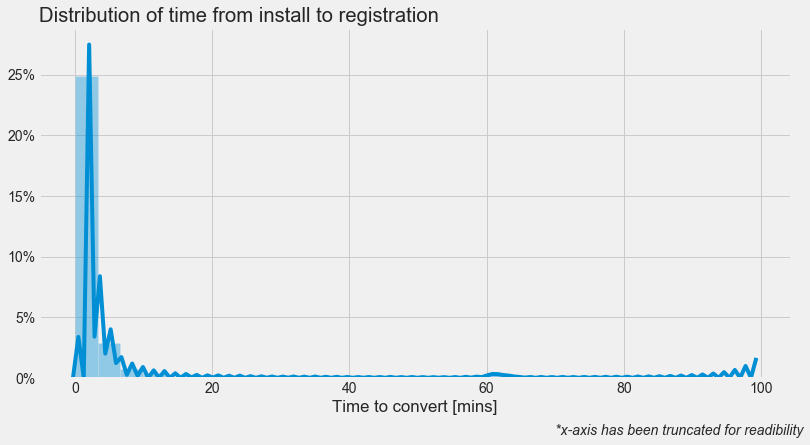

In [175]:
ax = sns.distplot(merged[merged.time_to_convert < 100]\
                      .time_to_convert\
                      .dropna(), 
                  bins = 30, 
                  kde = True)
ax.get_yaxis()\
    .set_major_formatter(
    mtick.FuncFormatter(lambda x, p: '{:,.0%}'.format(x))
)
plt.title("Distribution of time from install to registration", 
          loc = 'left')
plt.xlabel("Time to convert [mins]")
plt.text(70,-0.047,'*x-axis has been truncated for readibility', style='italic')
plt.show()

What about the metric evolution over time? It's important to understand what the behaviour of the baseline metric generally is over a period of a few weeks. 

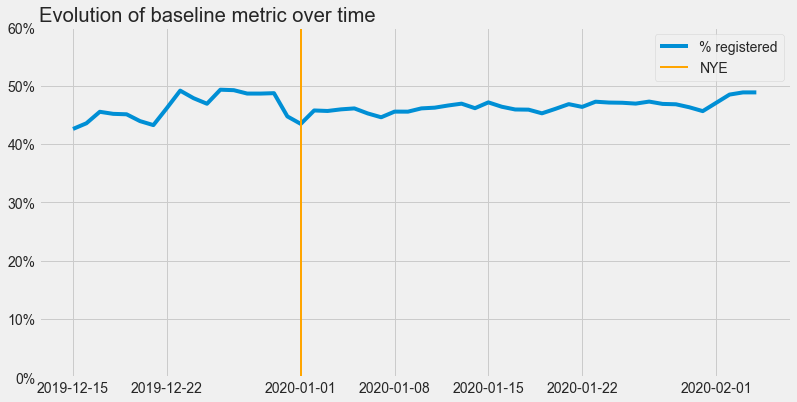

In [142]:
ax = sns.lineplot(data = merged.groupby(merged.installed.dt.date).converted.mean(), 
                  label = '% registered')
ax.get_yaxis()\
    .set_major_formatter(
    mtick.FuncFormatter(lambda x, p: '{:,.0%}'.format(x))
)
plt.ylim(0, 0.6)
plt.axvline(x = '2020-01-01', ymin = 0, 
            ymax = 1, 
            color = 'orange', 
            lw = 2, 
            label = 'NYE')
plt.title("Evolution of baseline metric over time", 
          loc = 'left')
plt.legend()
plt.show()

It looks like our metric suffers from some seasonal fluctuations, but is overall stable and can be chosen as a robust target metric for an experiment. 

### Ingredients we're missing

1. ~Baseline rate~
2. Traffic (cumulative)
3. Hypothesized effect size

Now, in order to calculate how long an experiment would take, in addition to the baseline rate, we also need an idea of the typical traffic we expect to see during the time of the experiment. So, once we know how many observations we need, we can also quickly say "how many days/weeks it will take to reach this number of observations".

In [147]:
# We group by the date and count the unique users
traffic = merged.groupby(merged.installed.dt.date).user_id.nunique()
traffic.head()

installed
2019-12-15    27841
2019-12-16    25113
2019-12-17    24476
2019-12-18    22591
2019-12-19    21101
Name: user_id, dtype: int64

In [178]:
traffic_cumulative = traffic.cumsum()
traffic_cumulative.head()

installed
2019-12-15     27841
2019-12-16     52954
2019-12-17     77430
2019-12-18    100021
2019-12-19    121122
Name: user_id, dtype: int64

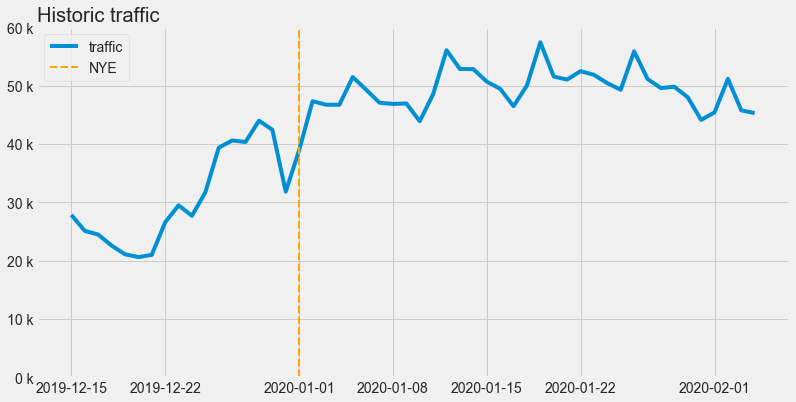

In [208]:
ax = sns.lineplot(data = traffic, 
                  label = 'traffic')
ax.get_yaxis()\
    .set_major_formatter(
    mtick.FuncFormatter(lambda x, p: '{:,.0f} k'.format(x/1000))
)
plt.ylim(0, 60000)
plt.axvline(x = '2020-01-01', ymin = 0, 
            ymax = 1, 
            color = 'orange', 
            lw = 2, 
            ls = '--',
            label = 'NYE')
plt.title("Historic traffic", 
          loc = 'left')
plt.legend()
plt.show()

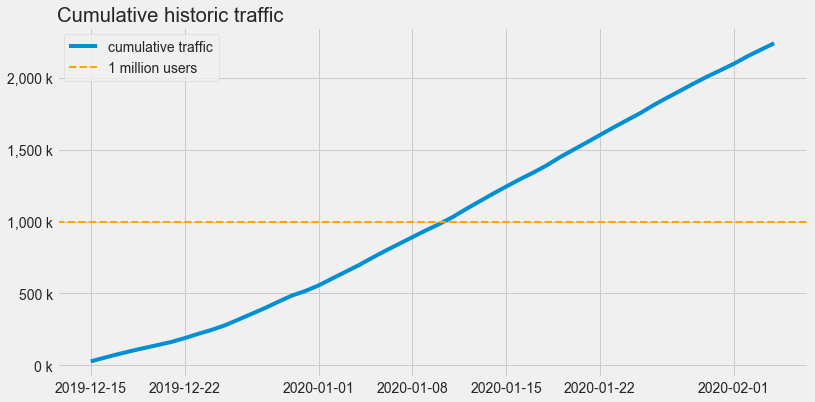

In [207]:
ax = sns.lineplot(data = traffic_cumulative, 
                  label = 'cumulative traffic')
ax.get_yaxis()\
    .set_major_formatter(
    mtick.FuncFormatter(lambda x, p: '{:,.0f} k'.format(x/1000))
)
plt.axhline(y = 1e6, xmin = 0, 
            xmax = 1, 
            color = 'orange', 
            lw = 2, 
            ls = '--',
            label = '1 million users')
plt.title("Cumulative historic traffic", 
          loc = 'left')
plt.legend()
plt.show()

#### Back to the ingredients
1. ~Baseline rate~
2. ~Traffic (cumulative)~
3. Hypothesized effect size

The topic of chosing a hypothesized effect size is a difficult one. Often this comes from expert knowledge, previous experiment performance, or simply is the minimum decision threshold for accepting a feature (perhaps because it is calculated as the breakeven point, given a certain false positive rate). 

For this example, let's assume we want to look at different effect sizes: 
[1%, 3%, 5%, 10%, 15%, 20%]

In [210]:
from scipy.stats import norm

In [211]:
merged.head()

,user_id,installed,registered,time_to_convert,converted
0,00000abd12e388,2019-12-17 23:32:27,2019-12-17 23:34:30.006,2.0,1
1,000012e7718804,2020-01-23 18:53:58,NaT,NaN,0
2,0000140c19946d,2020-01-28 22:06:25,2020-01-28 22:07:17.595,0.0,1
3,0000144dc06971,2020-01-20 10:23:23,2020-01-20 10:28:53.503,5.0,1
4,0000149d8ca325,2020-01-08 19:49:51,NaT,NaN,0


In [241]:
import numpy as np

In [247]:
merged.converted.std()

0.49878790501722553

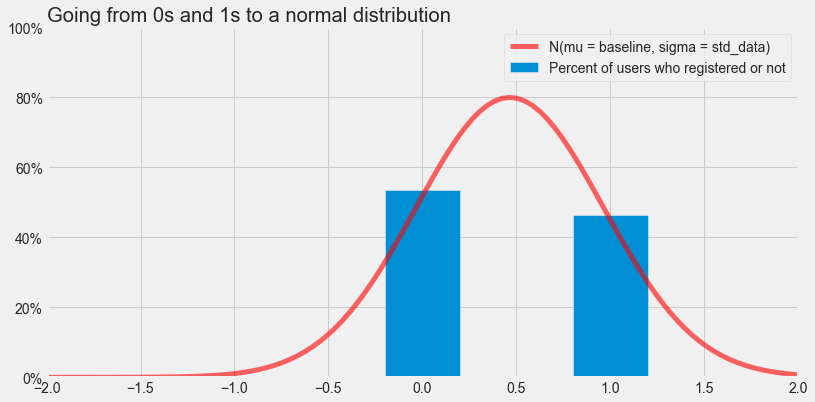

In [265]:
plt.bar(x = [0, 1], 
        height = merged.converted.value_counts(normalize = True), 
        width = 0.4, 
        label = "Percent of users who registered or not")
ax = plt.gca()
ax.get_yaxis()\
    .set_major_formatter(
    mtick.FuncFormatter(lambda x, p: '{:,.0%}'.format(x))
)
plt.ylim(0,1)
plt.xlim(-2,2)
plt.title("Going from 0s and 1s to a normal distribution", loc = 'left')

# Let's fit a normal curve C ~ N(baseline, std_data)
x = np.linspace(-2,2, 100)
ax.plot(x, 
        norm.pdf(x, 
                 loc = baseline, scale = merged.converted.std()),
        'r-', 
        lw=5, 
        alpha=0.6, 
        label='N(mu = baseline, sigma = std_data)')

plt.legend()
plt.show()

Now let's also overlay 

In [299]:
%%time

sample_means = []
for i in range(100):
    sample_mean = merged.converted.sample(2000).mean()
    sample_means.append(sample_mean)

CPU times: user 11.1 s, sys: 769 ms, total: 11.8 s
Wall time: 12.7 s


In [300]:
resampling_mean = np.mean(sample_means)
print("resampling mean:", resampling_mean)
resampling_std = np.std(sample_means)
print("resampling std:", resampling_std)

resampling mean: 0.4655700000000001
resampling std: 0.010430728641854306


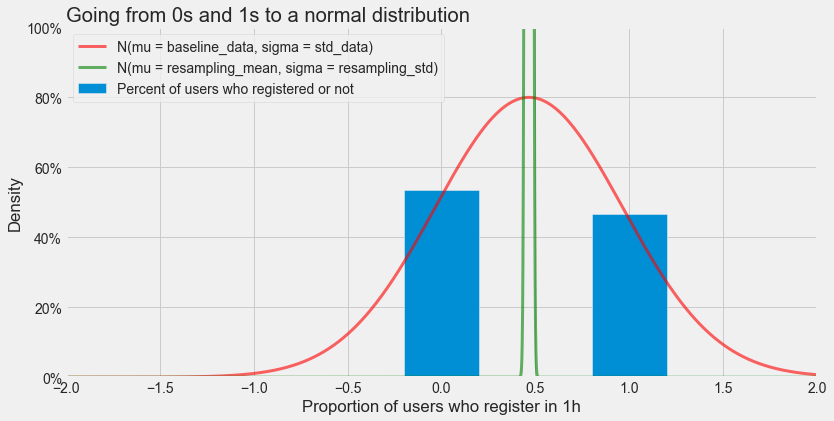

In [302]:
plt.bar(x = [0, 1], 
        height = merged.converted.value_counts(normalize = True), 
        width = 0.4, 
        label = "Percent of users who registered or not")
ax = plt.gca()
ax.get_yaxis()\
    .set_major_formatter(
    mtick.FuncFormatter(lambda x, p: '{:,.0%}'.format(x))
)
plt.ylim(0,1)
plt.xlim(-2,2)
plt.title("Going from 0s and 1s to a normal distribution", loc = 'left')

# Let's fit a normal curve C ~ N(baseline, std_data)
x = np.linspace(-2,2, 30000)
ax.plot(x, 
        norm.pdf(x, 
                 loc = baseline, scale = merged.converted.std()),
        'r-', 
        lw=3, 
        alpha=0.6, 
        label='N(mu = baseline_data, sigma = std_data)')

ax.plot(x, 
        norm.pdf(x, 
                 loc = resampling_mean, scale = resampling_std),
        '-g', 
        lw=3, 
        alpha=0.6, 
        label='N(mu = resampling_mean, sigma = resampling_std)')
plt.xlabel("Proportion of users who register in 1h")
plt.ylabel("Density")
plt.legend()
plt.show()

0.465146